# **CITY BIKE API**

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# API url
url = "http://api.citybik.es/v2/networks"

In [3]:
# parsed the data as JSON
response = requests.get(url).json()
# prints first 5 values
response['networks'][:5]

[{'company': ['ЗАО «СитиБайк»'],
  'href': '/v2/networks/velobike-moscow',
  'id': 'velobike-moscow',
  'location': {'city': 'Moscow',
   'country': 'RU',
   'latitude': 55.75,
   'longitude': 37.616667},
  'name': 'Velobike'},
 {'company': ['Comunicare S.r.l.'],
  'href': '/v2/networks/bicincitta-siena',
  'id': 'bicincitta-siena',
  'location': {'city': 'Siena',
   'country': 'IT',
   'latitude': 43.3186,
   'longitude': 11.3306},
  'name': 'Bicincittà',
  'source': 'https://www.bicincitta.com/frmLeStazioni.aspx?ID=202'},
 {'company': ['Cyclopolis Systems'],
  'href': '/v2/networks/cyclopolis-maroussi',
  'id': 'cyclopolis-maroussi',
  'location': {'city': 'Maroussi',
   'country': 'GR',
   'latitude': 38.0568722388,
   'longitude': 23.8083299536},
  'name': 'Cyclopolis'},
 {'company': ['Cyclopolis Systems'],
  'href': '/v2/networks/cyclopolis-nafplio',
  'id': 'cyclopolis-nafplio',
  'location': {'city': 'Nafplio',
   'country': 'GR',
   'latitude': 37.5639397319,
   'longitude': 22

> From the documentation, the API provides field filtering parameter and from the list of features in the JSON formatted data, I am interested in the name of the company providing the bike and the location of the company.

In [4]:
# API url with the filter parameter
urlFilter = "http://api.citybik.es/v2/networks?fields=name,location"

In [5]:
# parsed the data as JSON
responseFilter = requests.get(urlFilter).json()
# prints first 5 values
responseFilter['networks'][:5]

[{'location': {'city': 'Moscow',
   'country': 'RU',
   'latitude': 55.75,
   'longitude': 37.616667},
  'name': 'Velobike'},
 {'location': {'city': 'Siena',
   'country': 'IT',
   'latitude': 43.3186,
   'longitude': 11.3306},
  'name': 'Bicincittà'},
 {'location': {'city': 'Maroussi',
   'country': 'GR',
   'latitude': 38.0568722388,
   'longitude': 23.8083299536},
  'name': 'Cyclopolis'},
 {'location': {'city': 'Nafplio',
   'country': 'GR',
   'latitude': 37.5639397319,
   'longitude': 22.8093402872},
  'name': 'Cyclopolis'},
 {'location': {'city': 'Parco dei Colli di Bergamo',
   'country': 'IT',
   'latitude': 45.72295637032245,
   'longitude': 9.649230073016383},
  'name': 'Bicincittà'}]

> The result above shows that location information is stored in a dictionary.

## **PUT INFORMATION INTO A TABLE**

In [6]:
# create main dataframe
bike = pd.DataFrame()

# loop through the JSON formatted data
for i in range(len(responseFilter['networks'])):
    # create a temporary dataframe
    temp = pd.DataFrame(
        {
            'Name': [responseFilter['networks'][i]['name']],
            'Country': [responseFilter['networks'][i]['location']['country']],
            'City': [responseFilter['networks'][i]['location']['city']],
            'Latitude': [responseFilter['networks'][i]['location']['latitude']],
            'Longitude': [responseFilter['networks'][i]['location']['longitude']]
        }
    )

    # concatenate the temporary dataframe with the earlier created dataframe
    bike = pd.concat([bike, temp], ignore_index=True)

bike.head()

,Name,Country,City,Latitude,Longitude
0,Velobike,RU,Moscow,55.750000,37.616667
1,Bicincittà,IT,Siena,43.318600,11.330600
2,Cyclopolis,GR,Maroussi,38.056872,23.808330
3,Cyclopolis,GR,Nafplio,37.563940,22.809340
4,Bicincittà,IT,Parco dei Colli di Bergamo,45.722956,9.649230


# **REPLACE COUNTRY ABBREVIATION WITH FULLNAME**

> Replacing the country's abbreviated name with the fullname to help audience understand the dataset and resulting visualization.

In [7]:
from bs4 import BeautifulSoup
import csv

# Fetch the web page
url = 'https://www.iban.com/country-codes'
responseCountry = requests.get(url)
html_content = responseCountry.content

# Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table you want to scrape
table = soup.find('table')

# Extract the table rows
rows = table.find_all('tr')

# Open a CSV file to store the scraped data
with open('country_names.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in rows:
        # Extract the text from each table cell
        data = [cell.text.strip() for cell in row.find_all('td')]
        writer.writerow(data)


In [8]:
countryFullName = pd.read_csv('country_names.csv', encoding='ISO-8859-1', names=['Country', 'Alpha-2', 'Alpha-3', 'Numeric'])
countryFullName.head()

,Country,Alpha-2,Alpha-3,Numeric
0,Afghanistan,AF,AFG,4
1,Åland Islands,AX,ALA,248
2,Albania,AL,ALB,8
3,Algeria,DZ,DZA,12
4,American Samoa,AS,ASM,16


In [9]:
bike = pd.merge(bike, countryFullName, left_on='Country', right_on='Alpha-2', how='inner', suffixes=['_left', ''])
bike.head()

,Name,Country_left,City,Latitude,Longitude,Country,Alpha-2,Alpha-3,Numeric
0,Velobike,RU,Moscow,55.750000,37.616667,Russian Federation (the),RU,RUS,643
1,Bicincittà,IT,Siena,43.318600,11.330600,Italy,IT,ITA,380
2,Cyclopolis,GR,Maroussi,38.056872,23.808330,Greece,GR,GRC,300
3,Cyclopolis,GR,Nafplio,37.563940,22.809340,Greece,GR,GRC,300
4,Bicincittà,IT,Parco dei Colli di Bergamo,45.722956,9.649230,Italy,IT,ITA,380


In [10]:
bike.drop(['Country_left', 'Alpha-2', 'Alpha-3', 'Numeric'], axis=1, inplace=True)
bike.head()

,Name,City,Latitude,Longitude,Country
0,Velobike,Moscow,55.750000,37.616667,Russian Federation (the)
1,Bicincittà,Siena,43.318600,11.330600,Italy
2,Cyclopolis,Maroussi,38.056872,23.808330,Greece
3,Cyclopolis,Nafplio,37.563940,22.809340,Greece
4,Bicincittà,Parco dei Colli di Bergamo,45.722956,9.649230,Italy


In [11]:
bike.Country.unique()

array(['Russian Federation (the)', 'Italy', 'Greece', 'Ireland',
       'Thailand', 'Poland',
       'United Kingdom of Great Britain and Northern Ireland (the)',
       'United States of America (the)', 'Germany', 'Kazakhstan',
       'France', 'Spain', 'Mexico', 'Belgium', 'Sweden', 'Canada',
       'Brazil', 'Chile', 'Norway', 'Argentina', 'Portugal', 'Luxembourg',
       'Slovenia', 'Lithuania', 'Japan', 'Romania', 'Turkey', 'Finland',
       'Israel', 'Slovakia', 'Netherlands (the)', 'Colombia', 'Georgia',
       'Montenegro', 'Austria', 'Switzerland', 'Latvia', 'Cyprus',
       'New Zealand', 'Croatia', 'Ukraine', 'Malta',
       'Bosnia and Herzegovina', 'Hungary', 'Monaco', 'Czechia',
       'Ecuador', 'Peru', 'Korea (the Republic of)',
       'United Arab Emirates (the)', 'Saudi Arabia',
       'Taiwan (Province of China)', 'Aruba', 'China', 'Costa Rica',
       'India', 'Malaysia'], dtype=object)

In [12]:
bike['Country'].replace({
    'Russian Federation (the)': 'Russia',
    'United Kingdom of Great Britain and Northern Ireland (the)': 'United Kingdom',
    'United States of America (the)': 'United States',
    'Netherlands (the)': 'Netherlands',
    'Korea (the Republic of)': 'Korea',
    'United Arab Emirates (the)': 'United Arab Emirates',
    'Taiwan (Province of China)': 'Taiwan'
}, inplace=True)
bike.head()

C:\Users\Aduragbemi\AppData\Local\Temp\ipykernel_21892\2456486531.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bike['Country'].replace({


,Name,City,Latitude,Longitude,Country
0,Velobike,Moscow,55.750000,37.616667,Russia
1,Bicincittà,Siena,43.318600,11.330600,Italy
2,Cyclopolis,Maroussi,38.056872,23.808330,Greece
3,Cyclopolis,Nafplio,37.563940,22.809340,Greece
4,Bicincittà,Parco dei Colli di Bergamo,45.722956,9.649230,Italy


## **EXPLORATORY DATA ANALYSIS**

In [13]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       770 non-null    object 
 1   City       770 non-null    object 
 2   Latitude   770 non-null    float64
 3   Longitude  770 non-null    float64
 4   Country    770 non-null    object 
dtypes: float64(2), object(3)
memory usage: 30.2+ KB


> The result shows there are 770 rows and 5 features, no missing values, also the datatype of each feature appears to be appropriate.

#### **HOW MANY UNIQUE COUNTRIES AND CITIES ARE IN THE DATAFRAME?**

In [14]:
bike['Country'].nunique()

57

In [15]:
bike['City'].nunique()

750

> The outputs from the above cells tells that some countries and cities occurred more than once in the DataFrame, it would be a great idea to check for duplicates in the dataset so it doesn't affect the outcome of the analysis.

#### **CHECK FOR DUPLICATES IN THE DATASET**

In [16]:
bike.duplicated().sum()

0

> Even though the dataset have some countries and cities repeated, the result shows that there are no duplicate datapoint in the dataset.

## **DATA VISUALIZATION**

> Exploring the data as visuals

In [17]:
# sort values in ascending order and gets the index
country_count = bike['Country'].value_counts().index 

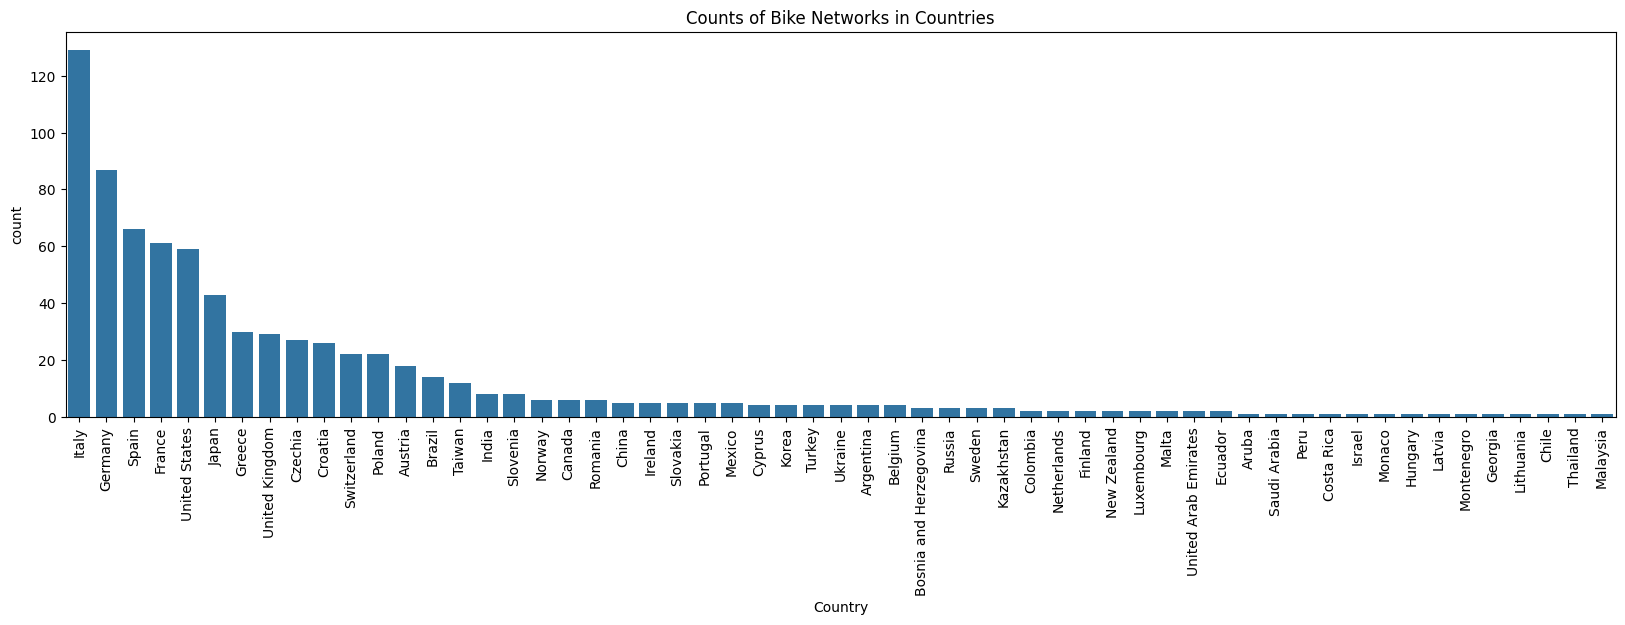

In [18]:
plt.figure(figsize=(20, 5)) # changes the figure size
sns.countplot(data=bike, x=bike['Country'], order=country_count);

plt.title('Counts of Bike Networks in Countries');
plt.xticks(rotation=90);

> Italy have the highest number of bike networks in the world according to the data from the API.

### **TOP 10 COUNTRIES WITH BIKE NETWORKS**

In [19]:
top10countries = bike.groupby('Country').count().sort_values(by='Name', ascending=False)\
                    .reset_index()[:10]

In [20]:
top10countries

,Country,Name,City,Latitude,Longitude
0,Italy,129,129,129,129
1,Germany,87,87,87,87
2,Spain,66,66,66,66
3,France,61,61,61,61
4,United States,59,59,59,59
5,Japan,43,43,43,43
6,Greece,30,30,30,30
7,United Kingdom,29,29,29,29
8,Czechia,27,27,27,27
9,Croatia,26,26,26,26


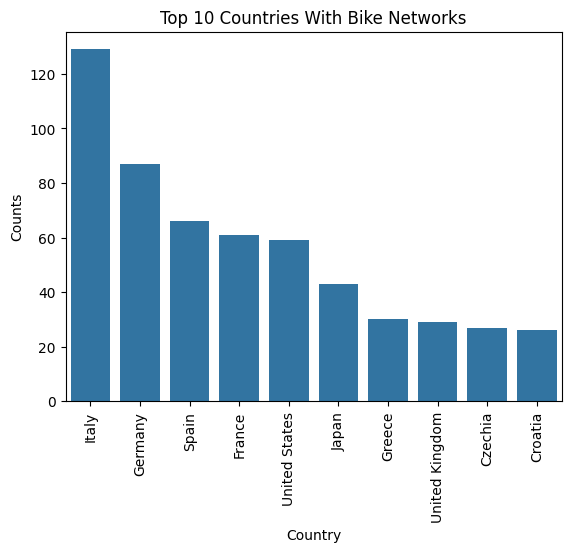

In [21]:
sns.barplot(data=top10countries, x=top10countries['Country'], y=top10countries['Name']);
plt.title('Top 10 Countries With Bike Networks');
plt.xticks(rotation=90);
plt.ylabel('Counts');

> The top ten countries with bike networks are Italy, Germany, Spain, France, United States, Japan, Greece, United Kingdom, Czech Republic, Croatia.

# **LOOKING INTO A PARTICULAR COMPANY**

> I will be looking into companies in the US for this analysis.

In [22]:
bike.query('Country == "US"').head(7)

,Name,City,Latitude,Longitude,Country


> I will be using the _Bubler Bikes_ bike sharing network for my analysis, before that I need the network's id.

In [23]:
response['networks'][86]

{'company': ['BCycle, LLC'],
 'gbfs_href': 'https://gbfs.bcycle.com/bcycle_bublr/gbfs.json',
 'href': '/v2/networks/bublr-bikes',
 'id': 'bublr-bikes',
 'location': {'city': 'Milwaukee, WI',
  'country': 'US',
  'latitude': 43.0369,
  'longitude': -87.89667},
 'name': 'Bublr Bikes'}

## **BUBLR BIKE NETWORK**

In [24]:
# the Bublr Bike Network url
BBurl = "http://api.citybik.es/v2/networks/bublr-bikes"

In [25]:
BBdata = requests.get(BBurl).json()
BBdata['network']['stations'][:5]

[{'empty_slots': 10,
  'extra': {'address': '1420 N. Marshall St.',
   'ebikes': 4,
   'has_ebikes': True,
   'last_updated': 1712950022,
   'normal_bikes': 1,
   'rental_uris': {'android': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=android',
    'ios': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=iOS'},
   'renting': 1,
   'returning': 1,
   'uid': 'bcycle_bublr_3326'},
  'free_bikes': 5,
  'id': '4b562f25ad06507ac8ab4b8a118b0f24',
  'latitude': 43.0482,
  'longitude': -87.90086,
  'name': 'Ogden & Marshall',
  'timestamp': '2024-04-12T19:27:52.135000Z'},
 {'empty_slots': 11,
  'extra': {'address': '686 N. 8th St.',
   'ebikes': 0,
   'has_ebikes': True,
   'last_updated': 1712950022,
   'normal_bikes': 4,
   'rental_uris': {'android': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3327&platform=android',
    'ios': 'https://www.bcycle.com/applink?system_id

In [26]:
# gets the first station of the Bublr Bike Network
BBdata['network']['stations'][0]

{'empty_slots': 10,
 'extra': {'address': '1420 N. Marshall St.',
  'ebikes': 4,
  'has_ebikes': True,
  'last_updated': 1712950022,
  'normal_bikes': 1,
  'rental_uris': {'android': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=android',
   'ios': 'https://www.bcycle.com/applink?system_id=bcycle_bublr&station_id=bcycle_bublr_3326&platform=iOS'},
  'renting': 1,
  'returning': 1,
  'uid': 'bcycle_bublr_3326'},
 'free_bikes': 5,
 'id': '4b562f25ad06507ac8ab4b8a118b0f24',
 'latitude': 43.0482,
 'longitude': -87.90086,
 'name': 'Ogden & Marshall',
 'timestamp': '2024-04-12T19:27:52.135000Z'}

> What each keys in the network represents:

- empty_slots: The number of docks available for returning bikes.
- extra: Contains miscellaneous additional information, often including the station’s address.
- ebikes: The count of electric bikes available at the station.
- has_ebikes: A boolean (true/false) indicating if there are electric bikes at the station.
- last_updated: The Unix timestamp for when the station’s information was last updated.
- normal_bikes: The number of standard, non-electric bikes available.
- rental_uris: URLs for mobile applications to rent bikes.
- renting: A boolean indicating if the station is currently allowing rentals.
- returning: A boolean indicating if bikes can be returned at the moment.
- uid: A unique identifier for the station.
- free_bikes: The total number of bikes available for rent, including electric ones.
- id: Another identifier for the station, possibly internal.
- latitude and longitude: The geographical coordinates of the station.
- name: The name of the station.
- timestamp: The Unix timestamp for when this data snapshot was taken.

## **FEATURE ENGINEERING**

> Since some of the data in the dictionary are repeated, I will only be using a few of the values in the dictionary, these values includes:

- uid
- empty_slots
- ebikes
- has_ebikes
- normal_bikes
- renting
- returning
- latitude
- longitude
- free_bikes

Using the latitude and longitude again because the geographical coordinates of the stations differ from each other.

In [27]:
# main DataFrame to hold collected data
BBframe = pd.DataFrame()

# loop through the stations
for i in range(len(BBdata['network']['stations'])):
    # creates a temporaty DataFrame
    temp = pd.DataFrame(
        {
           'uid': [BBdata['network']['stations'][i]['extra']['uid']],
           'empty_slots': [BBdata['network']['stations'][i]['empty_slots']],
           'ebikes': [BBdata['network']['stations'][i]['extra']['ebikes']],
           'has_ebikes': [BBdata['network']['stations'][i]['extra']['has_ebikes']],
           'normal_bikes': [BBdata['network']['stations'][i]['extra']['normal_bikes']],
           'renting': [BBdata['network']['stations'][i]['extra']['renting']],
           'returning': [BBdata['network']['stations'][i]['extra']['returning']],
           'latitude': [BBdata['network']['stations'][i]['latitude']],
           'longitude': [BBdata['network']['stations'][i]['longitude']],
           'free_bikes': [BBdata['network']['stations'][i]['free_bikes']]
        }
    )
    # combines both the main and temporary DataFrame
    BBframe = pd.concat([BBframe, temp], ignore_index=True)

## **LOAD DATAFRAME**

In [28]:
BBframe.head()

,uid,empty_slots,ebikes,has_ebikes,normal_bikes,renting,returning,latitude,longitude,free_bikes
0,bcycle_bublr_3326,10,4,True,1,1,1,43.04820,-87.90086,5
1,bcycle_bublr_3327,11,0,True,4,1,1,43.03865,-87.92193,4
2,bcycle_bublr_3489,9,1,True,3,1,1,43.04782,-87.89565,4
3,bcycle_bublr_3325,12,0,True,3,1,1,43.04824,-87.90497,3
4,bcycle_bublr_3322,3,1,True,11,1,1,43.02871,-87.90410,12


In [29]:
BBframe.shape

(117, 10)

In [30]:
BBframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           117 non-null    object 
 1   empty_slots   117 non-null    int64  
 2   ebikes        117 non-null    int64  
 3   has_ebikes    117 non-null    bool   
 4   normal_bikes  117 non-null    int64  
 5   renting       117 non-null    int64  
 6   returning     117 non-null    int64  
 7   latitude      117 non-null    float64
 8   longitude     117 non-null    float64
 9   free_bikes    117 non-null    int64  
dtypes: bool(1), float64(2), int64(6), object(1)
memory usage: 8.5+ KB


In [31]:
BBframe.describe()

,empty_slots,ebikes,normal_bikes,renting,returning,latitude,longitude,free_bikes
count,117.000000,117.000000,117.000000,117.0,117.0,117.000000,117.000000,117.000000
mean,7.726496,1.170940,4.059829,1.0,1.0,43.044118,-87.936371,5.230769
std,3.395291,1.275029,2.997961,0.0,0.0,0.018257,0.046122,2.901797
min,1.000000,0.000000,0.000000,1.0,1.0,42.993390,-88.043410,1.000000
25%,5.000000,0.000000,2.000000,1.0,1.0,43.031480,-87.976150,3.000000
50%,7.000000,1.000000,3.000000,1.0,1.0,43.045620,-87.916910,4.000000
75%,10.000000,2.000000,6.000000,1.0,1.0,43.057400,-87.904100,7.000000
max,20.000000,7.000000,14.000000,1.0,1.0,43.100150,-87.877300,14.000000


## **DATA VISUALIZATION**

> Distribution of the numerical features of the dataset.

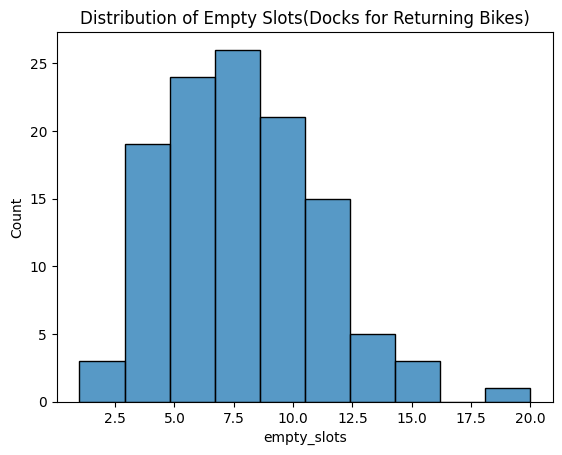

In [32]:
sns.histplot(data=BBframe, x=BBframe['empty_slots']);
plt.title('Distribution of Empty Slots(Docks for Returning Bikes)');

> The chart above informs that for stations in the Bublr bikes network, the highest number of empty slots for returning bikes is 7.

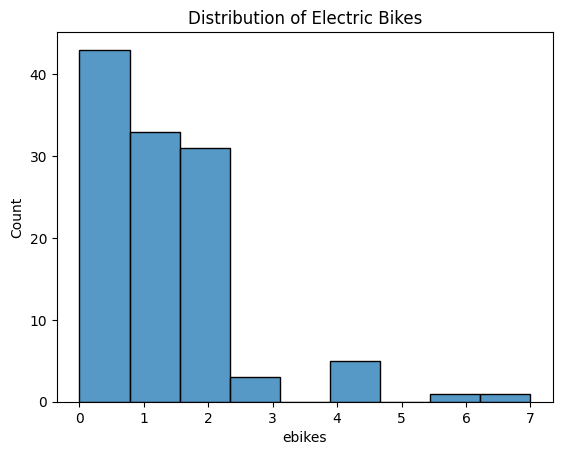

In [33]:
sns.histplot(data=BBframe, x=BBframe['ebikes']);
plt.title('Distribution of Electric Bikes');

> Most stations in the Bublr bikes have no electric bikes in their stations and a few of the stations have 4 - 5 electric bikes.

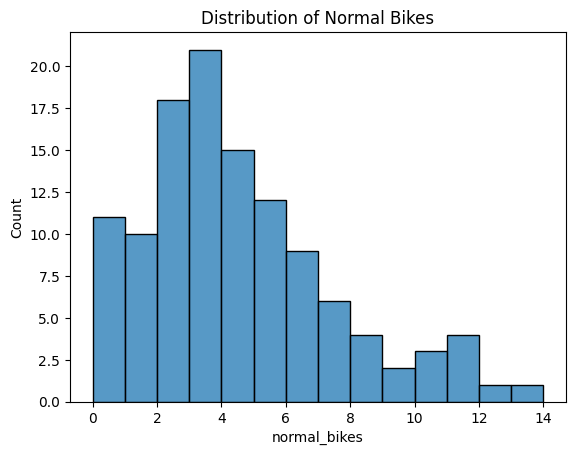

In [34]:
sns.histplot(data=BBframe, x=BBframe['normal_bikes'], binwidth=1);
plt.title('Distribution of Normal Bikes');

> The above shows that the distribution of the normal bikes in the stations are right skewed and most of the stations have 2 - 5 bikes available for renting.

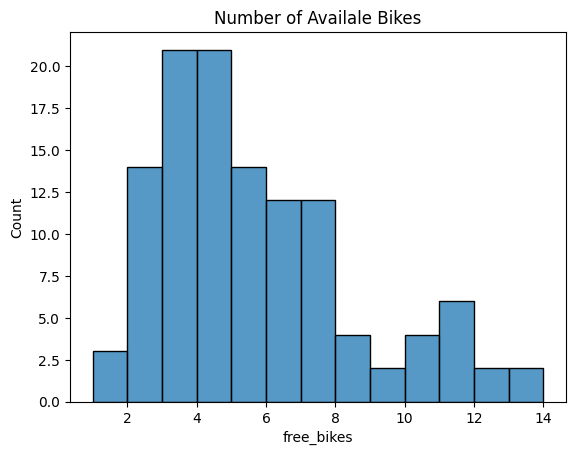

In [35]:
sns.histplot(data=BBframe, x=BBframe['free_bikes'], binwidth=1);
plt.title('Number of Availale Bikes');

> The plot above is right skewed and it also indicates that for most stations the number of available bikes for renting - both electric and normal bikes, is 3.